In [43]:
import pandas as pd
import sys
sys.path.append('..')
import db
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math


In [44]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [45]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _201904 where monthly_salary>0 and monthly_salary<15", con=conn)
conn.close()

In [46]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [47]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [48]:
def get_sub_stats(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    count=[]
    for feature in features:
        salary_mean.append(data[data[feature]==1].monthly_salary.mean()*10000)
        salary_median.append(data[data[feature]==1].monthly_salary.median()*10000)
        count.append(data[data[feature]==1].shape[0])
    sub_data=pd.DataFrame()
    sub_data[prefix]=[f.replace(prefix,'') for f in features]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

In [49]:
data_city=get_sub_stats(data,'city_')
data_city.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,17453,15000,13823,9.90%
17,shanghai,16626,15000,25888,18.55%
19,shenzhen,15631,14000,20757,14.87%
9,hangzhou,14977,12500,8690,6.23%
8,guangzhou,13032,12000,17068,12.23%
14,nanjing,12874,12500,7091,5.08%
3,chengdu,11896,11500,7028,5.04%
6,dongguan,11353,10417,1632,1.17%
22,xian,11075,10000,3833,2.75%
21,wuhan,11074,10417,8027,5.75%


程序员收入最高的城市分别为：北京，上海，深圳，广州

In [50]:
translate_dict={}
translate_dict['beijing']='北京'
translate_dict['shanghai']='上海'
translate_dict['shenzhen']='深圳'
translate_dict['hangzhou']='杭州'
translate_dict['guangzhou']='广州'
translate_dict['nanjing']='南京'
translate_dict['chengdu']='成都'
translate_dict['dongguan']='东莞'
translate_dict['xian']='西安'
translate_dict['wuhan']='武汉'
translate_dict['tianjin']='天津'
translate_dict['changsha']='长沙'
translate_dict['ningbo']='宁波'
translate_dict['fuzhou']='福州'
translate_dict['dalian']='大连'
translate_dict['chongqing']='重庆'
translate_dict['qingdao']='青岛'
translate_dict['jinan']='济南'
translate_dict['hefei']='合肥'
translate_dict['changchun']='长春'
translate_dict['kuming']='昆明'
translate_dict['zhengzhou']='郑州'
translate_dict['shenyang']='沈阳'
translate_dict['harbin']='哈尔滨'


In [51]:
data_location = pd.read_csv('city_locations.csv')
data_location=data_location.set_index('city')

In [52]:
from mpl_toolkits.basemap import Basemap

In [53]:
def draw_map(data_city, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='states', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city.salary_mean.min()
    salary_max=data_city.salary_mean.max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        city=row[0]
        city_cn=translate_dict[city]
        longitude = data_location.loc[city_cn,'longitude']
        latitude = data_location.loc[city_cn,'latitude']
        salary=row[1]
        headcount=row[3]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/2000))*scale+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(headcount/3000+13)
        if city == 'hangzhou':
            x=x-400000
            y=y+10000
        elif city=='guangzhou':
            x=x-400000
            y=y+10000
        elif city=='hefei':
            x=x-300000
            y=y+10000
        elif city=='shenzhen':
            y=y-100000
        elif city=='nanjing':
            x=x-50000
        elif city=='tianjin':
            y=y-50000
        elif city=='shanghai':
            x=x+50000
        elif city=='wuhan':
            y=y-50000

        ax.text(x, y, "{}{:.0f}k".format(city_cn, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(city_cn, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表程序员数量，颜色代表工资，红色最高，黄色次之，蓝最少）".format(city_cn, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


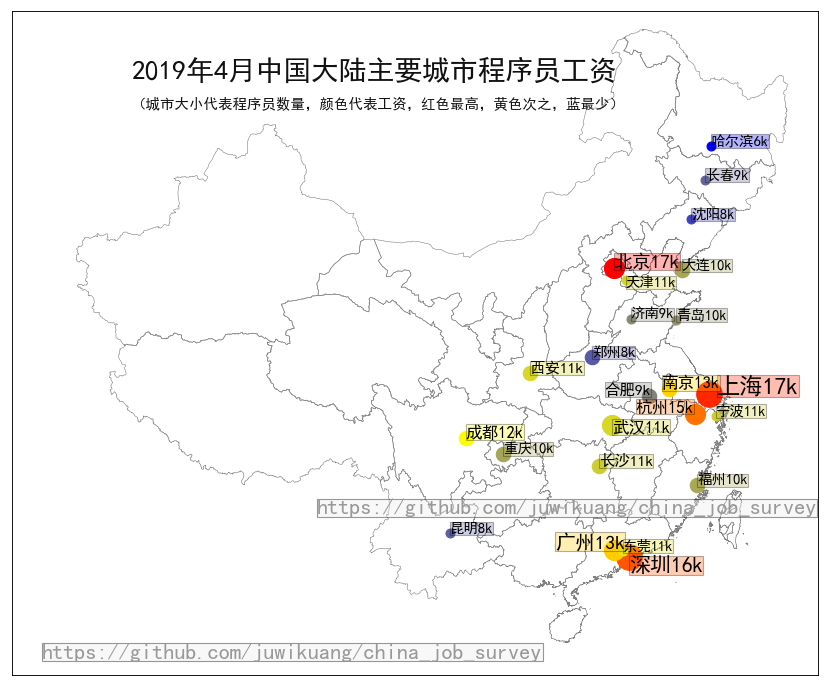

In [54]:
draw_map(data_city,'2019年4月中国大陆主要城市程序员工资')

In [55]:
data_city_software_engineer = get_sub_stats(data[data.career_software_engineer==1],'city_')

In [56]:
data_city_software_engineer.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,15767,14000,11285,9.35%
17,shanghai,15505,14583,22154,18.35%
19,shenzhen,14608,12500,17974,14.89%
9,hangzhou,13792,12500,7346,6.08%
8,guangzhou,12278,11500,15049,12.46%
14,nanjing,12164,11500,6173,5.11%
3,chengdu,11180,10500,6129,5.08%
6,dongguan,10714,10000,1428,1.18%
20,tianjin,10639,9000,1019,0.84%
22,xian,10453,9500,3346,2.77%


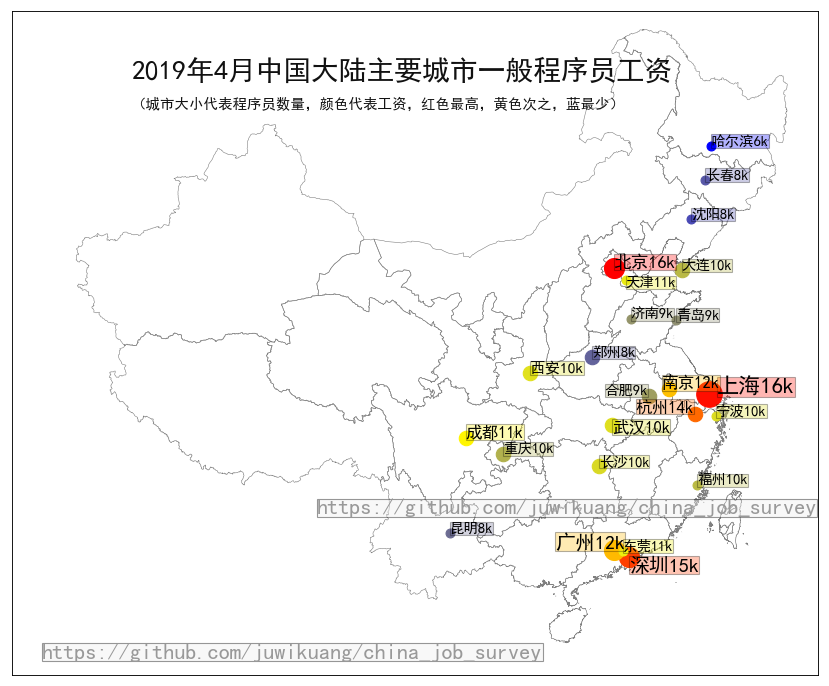

In [57]:
draw_map(data_city_software_engineer,'2019年4月中国大陆主要城市一般程序员工资')

In [58]:
data_city_architect = get_sub_stats(data[data.career_architect==1],'city_')

In [59]:
data_city_architect.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,26458,25000,734,11.78%
17,shanghai,24872,23000,1306,20.95%
9,hangzhou,24866,22500,388,6.22%
19,shenzhen,24544,22500,927,14.87%
8,guangzhou,19926,20000,843,13.52%
14,nanjing,19346,17500,258,4.14%
3,chengdu,18350,17500,291,4.67%
22,xian,18324,17500,147,2.36%
1,changchun,17910,9000,25,0.40%
5,dalian,17813,17500,78,1.25%


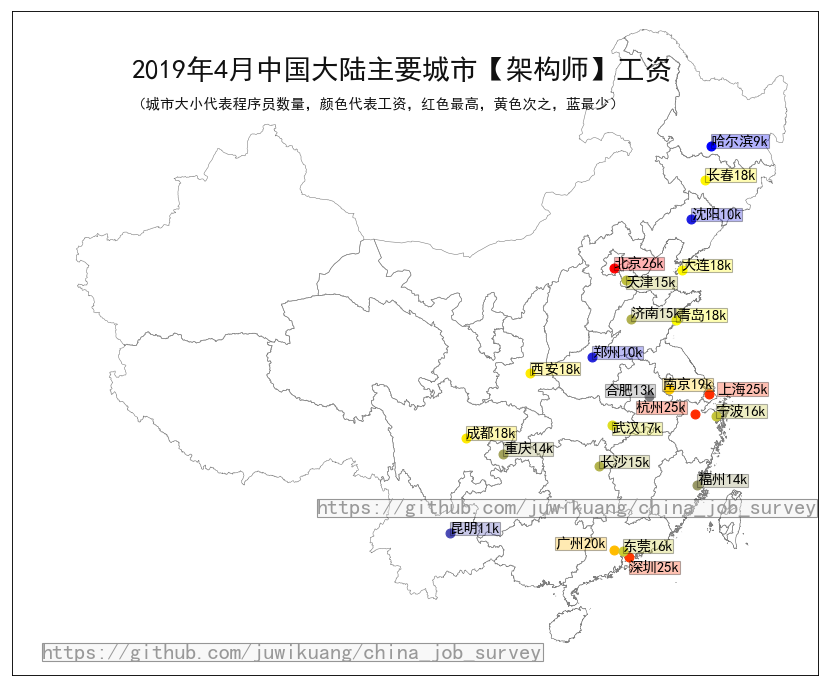

In [60]:
draw_map(data_city_architect,'2019年4月中国大陆主要城市【架构师】工资')

In [61]:
data_city_algorithm = get_sub_stats(data[data.career_algorithm==1],'city_')
data_city_algorithm.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,24450,22500,1783,14.38%
17,shanghai,22577,20833,2377,19.16%
19,shenzhen,21235,20000,1823,14.70%
9,hangzhou,20130,18500,944,7.61%
8,guangzhou,17820,15500,1157,9.33%
14,nanjing,17041,15000,649,5.23%
3,chengdu,16148,15000,598,4.82%
6,dongguan,15853,14000,125,1.01%
21,wuhan,15034,14250,660,5.32%
15,ningbo,14987,13000,83,0.67%


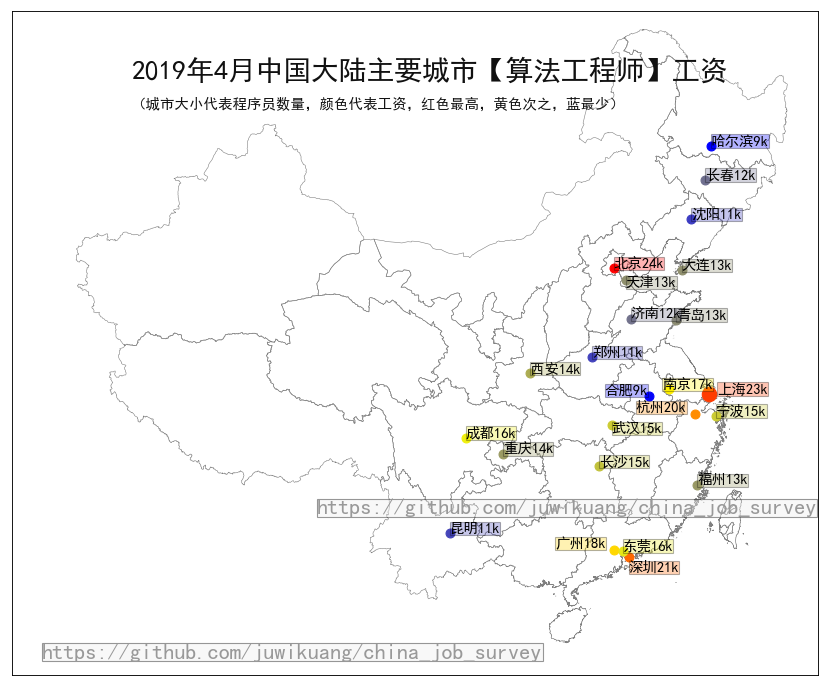

In [62]:
draw_map(data_city_algorithm,'2019年4月中国大陆主要城市【算法工程师】工资')

In [63]:
data_city_java = get_sub_stats(data[data.pl_java==1],'city_')
data_city_java.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
17,shanghai,17299,16667,9854,18.48%
0,beijing,17242,15000,5699,10.69%
19,shenzhen,16483,15000,7032,13.19%
9,hangzhou,15568,14000,3451,6.47%
8,guangzhou,13605,12500,6475,12.14%
14,nanjing,13139,12500,3032,5.69%
3,chengdu,12200,11500,2561,4.80%
6,dongguan,11611,11500,453,0.85%
15,ningbo,11469,10417,527,0.99%
21,wuhan,11391,10500,2823,5.29%


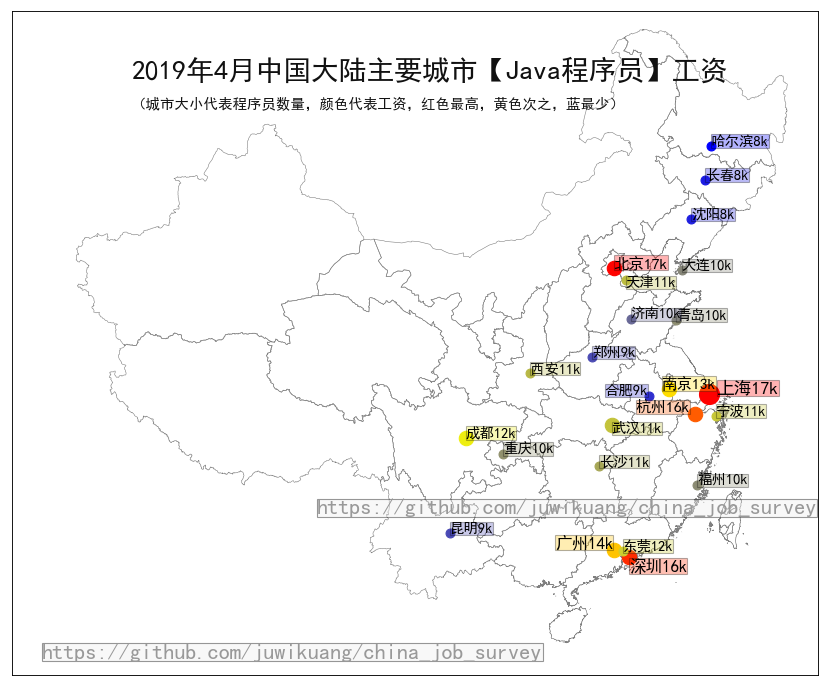

In [64]:
draw_map(data_city_java,'2019年4月中国大陆主要城市【Java程序员】工资')

In [65]:
data_city_python = get_sub_stats(data[data.pl_python==1],'city_')
data_city_python.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,city_,salary_mean,salary_median,head_count,percentage
0,beijing,22136,20000,2250,15.05%
17,shanghai,19929,17500,3431,22.96%
19,shenzhen,19353,17500,2041,13.66%
9,hangzhou,18556,17500,1053,7.05%
8,guangzhou,16347,15000,1633,10.93%
14,nanjing,14977,14000,802,5.37%
3,chengdu,14922,12500,784,5.25%
21,wuhan,13580,12500,701,4.69%
20,tianjin,13436,12500,109,0.73%
22,xian,13431,12500,379,2.54%


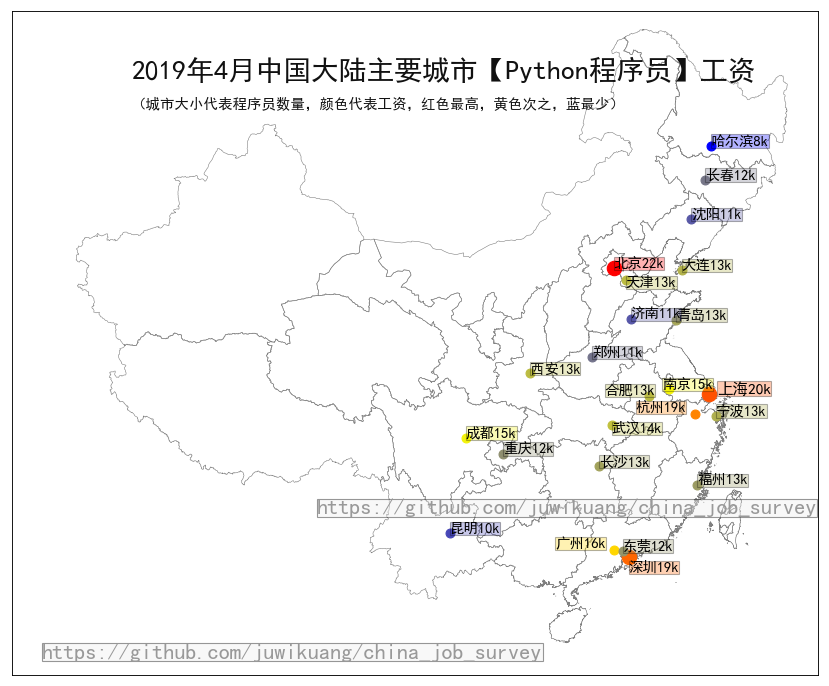

In [66]:
draw_map(data_city_python,'2019年4月中国大陆主要城市【Python程序员】工资')

In [67]:
int(data[data.pl_java].monthly_salary.mean() * 10000)

14155

In [68]:
int(data[data.pl_python].monthly_salary.mean() * 10000)

17751

In [84]:
int(data[data.pl_cpp].monthly_salary.mean() * 10000)

15869

In [85]:
int(data[data.pl_php].monthly_salary.mean() * 10000)

13163

In [86]:
int(data[data.pl_c_sharp].monthly_salary.mean() * 10000)

12008

In [69]:
int(data[data.career_software_engineer].monthly_salary.mean() * 10000)

12817

In [70]:
int(data[data.career_architect].monthly_salary.mean() * 10000)

21490

In [71]:
int(data[data.career_algorithm].monthly_salary.mean() * 10000)

19014

In [72]:
int(data[data.career_spider].monthly_salary.mean() * 10000)

13876

In [73]:
data[data.career_architect].pl_java.sum()

3168

In [74]:
data[data.career_architect].career_architect.sum()

6233

In [75]:
data[data.career_architect].pl_python.sum()

796

In [76]:
data[data.career_architect].pl_c_sharp.sum()

647

In [77]:
data[data.career_architect].pl_cpp.sum()

827

In [78]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    print(data[data.career_architect].sum())

ageism                              163.0
career_algorithm                      0.0
career_architect                   6233.0
career_software_engineer              0.0
city_beijing                        734.0
city_changchun                       25.0
city_changsha                       143.0
city_chengdu                        291.0
city_chongqing                      101.0
city_dalian                          78.0
city_dongguan                        78.0
city_fuzhou                          66.0
city_guangzhou                      843.0
city_hangzhou                       388.0
city_harbin                          18.0
city_hefei                           93.0
city_jinan                           40.0
city_kuming                          34.0
city_nanjing                        258.0
city_ningbo                          54.0
city_qingdao                         55.0
city_shanghai                      1306.0
city_shenyang                        59.0
city_shenzhen                     

In [79]:
data[data.career_architect].sum().tail(50)

non_996                1282.0
phone_android           224.0
phone_app               301.0
phone_iso                71.0
pl_assembly              11.0
pl_c_sharp              647.0
pl_cpp                  827.0
pl_delphi                13.0
pl_go                  1160.0
pl_groovy                12.0
pl_haskell                2.0
pl_java                3168.0
pl_javascript           801.0
pl_julia                  0.0
pl_kotlin                10.0
pl_lua                   62.0
pl_matlab                23.0
pl_objective_c            2.0
pl_perl                  85.0
pl_php                  545.0
pl_python               796.0
pl_ruby                  41.0
pl_rust                   9.0
pl_scala                175.0
pl_swift                 18.0
pl_typescript            21.0
pl_vba                    2.0
pl_visual_basic           0.0
pl_visual_basic_net       6.0
pl_r                     28.0
tag_baby_care             0.0
tag_five_insurance     4709.0
tag_flexible           1526.0
tag_no_ove

In [80]:
pd.options.display.max_rows = 200

In [81]:
data[data.career_architect].sum()

ageism                               163.000000
career_algorithm                       0.000000
career_architect                    6233.000000
career_software_engineer               0.000000
city_beijing                         734.000000
city_changchun                        25.000000
city_changsha                        143.000000
city_chengdu                         291.000000
city_chongqing                       101.000000
city_dalian                           78.000000
city_dongguan                         78.000000
city_fuzhou                           66.000000
city_guangzhou                       843.000000
city_hangzhou                        388.000000
city_harbin                           18.000000
city_hefei                            93.000000
city_jinan                            40.000000
city_kuming                           34.000000
city_nanjing                         258.000000
city_ningbo                           54.000000
city_qingdao                          55

In [82]:
data.sum()

ageism                               3199.0000
career_algorithm                    12403.0000
career_architect                     6233.0000
career_software_engineer           120746.0000
city_beijing                        13823.0000
city_changchun                        614.0000
city_changsha                        3354.0000
city_chengdu                         7028.0000
city_chongqing                       2570.0000
city_dalian                          2889.0000
city_dongguan                        1632.0000
city_fuzhou                          2085.0000
city_guangzhou                      17068.0000
city_hangzhou                        8690.0000
city_harbin                           870.0000
city_hefei                           3071.0000
city_jinan                           1479.0000
city_kuming                          1011.0000
city_nanjing                         7091.0000
city_ningbo                          1485.0000
city_qingdao                         1385.0000
city_shanghai

In [83]:
data[data.career_architect].sum() / data.sum()

ageism                             0.050953
career_algorithm                   0.000000
career_architect                   1.000000
career_software_engineer           0.000000
city_beijing                       0.053100
city_changchun                     0.040717
city_changsha                      0.042636
city_chengdu                       0.041406
city_chongqing                     0.039300
city_dalian                        0.026999
city_dongguan                      0.047794
city_fuzhou                        0.031655
city_guangzhou                     0.049391
city_hangzhou                      0.044649
city_harbin                        0.020690
city_hefei                         0.030283
city_jinan                         0.027045
city_kuming                        0.033630
city_nanjing                       0.036384
city_ningbo                        0.036364
city_qingdao                       0.039711
city_shanghai                      0.050448
city_shenyang                   